# CIFAR 10 CNN

Based on starter code from [here](https://github.com/santanu13/CIFAR_10_Classification_TPU).

In [3]:
#Import libraries

import os
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

#Download dataset

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 3s 0us/step


In [0]:
# normalize inputs from 0-255 to 0.0-1.0
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.0
x_test = x_test / 255.0

In [0]:
x_train=np.dot(x_train[...,:3], [0.299, 0.587, 0.114])
x_test=np.dot(x_test[...,:3], [0.299, 0.587, 0.114])
# add empty color dimension
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [6]:
#Split the dataset into train and valid
s = StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=1/6)
train_index, valid_index = next(s.split(x_train, y_train))
x_valid, y_valid = x_train[valid_index], y_train[valid_index]
x_train, y_train = x_train[train_index], y_train[train_index]
print(x_train.shape, x_valid.shape, x_test.shape)

(41666, 32, 32, 1) (8334, 32, 32, 1) (10000, 32, 32, 1)


In [24]:
model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
model.add(tf.keras.layers.Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Conv2D(32, (3, 3)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

# model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
model.add(tf.keras.layers.Conv2D(64, (3, 3)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

# model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
# model.add(tf.keras.layers.Conv2D(256, (5, 5)))
# model.add(tf.keras.layers.Activation('relu'))
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10))
model.add(tf.keras.layers.Activation('sigmoid'))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 30, 30, 32)        320       
_________________________________________________________________
activation_21 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_22 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 12, 12, 64)       

In [0]:
# tpu_model = tf.contrib.tpu.keras_to_tpu_model(
#     model,
#     strategy=tf.contrib.tpu.TPUDistributionStrategy(
#         tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
#     )
# )
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate= 0.001 ),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['sparse_categorical_accuracy']
)

In [26]:
%%time

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)
 
    
batch_size=128
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2, verbose=1)
history=model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    epochs=50,
    steps_per_epoch=int(np.ceil(x_train.shape[0] / batch_size)),
    validation_data=(x_valid, y_valid),callbacks=[early_stop]
)

Epoch 1/30
326/326 [==============================] - 119s 364ms/step - loss: 1.9249 - sparse_categorical_accuracy: 0.2946 - val_loss: 1.5933 - val_sparse_categorical_accuracy: 0.4376
Epoch 2/30
326/326 [==============================] - 123s 376ms/step - loss: 1.5813 - sparse_categorical_accuracy: 0.4336 - val_loss: 1.3662 - val_sparse_categorical_accuracy: 0.5197
Epoch 3/30
326/326 [==============================] - 119s 365ms/step - loss: 1.4110 - sparse_categorical_accuracy: 0.4983 - val_loss: 1.2050 - val_sparse_categorical_accuracy: 0.5775
Epoch 4/30
326/326 [==============================] - 119s 365ms/step - loss: 1.3157 - sparse_categorical_accuracy: 0.5370 - val_loss: 1.1542 - val_sparse_categorical_accuracy: 0.5912
Epoch 5/30
326/326 [==============================] - 119s 365ms/step - loss: 1.2502 - sparse_categorical_accuracy: 0.5624 - val_loss: 1.1221 - val_sparse_categorical_accuracy: 0.6036
Epoch 6/30
326/326 [==============================] - 119s 366ms/step - loss: 1.

In [27]:
%%time
# Evaluate the model on valid set
score = model.evaluate(x_valid, y_valid, verbose=0)

# Print test accuracy
print('\n', 'Valid accuracy:', score[1])


 Valid accuracy: 0.7399808168411255
CPU times: user 9.61 s, sys: 176 ms, total: 9.78 s
Wall time: 5.18 s


In [29]:
%%time
# Evaluate the model on test set
score = model.evaluate(x_test, y_test, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.7404999732971191
CPU times: user 11.6 s, sys: 199 ms, total: 11.8 s
Wall time: 6.24 s


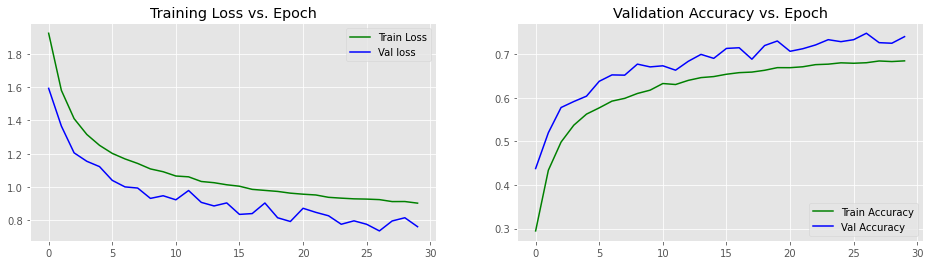

In [30]:
# For visually better looking plots
import matplotlib.pyplot as plt
# Changing default figure size for properly accomodating images
from pylab import rcParams
rcParams['figure.figsize'] = (16, 4)
plt.style.use('ggplot')

f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.set_title('Training Loss vs. Epoch')
ax2.set_title('Validation Accuracy vs. Epoch')

ax1.plot(history.history['loss'], color='green', label='Train Loss')
ax1.plot(history.history['val_loss'], color='blue', label='Val loss')

ax2.plot(history.history['sparse_categorical_accuracy'], color='green', label='Train Accuracy')
ax2.plot(history.history['val_sparse_categorical_accuracy'], color='blue', label='Val Accuracy')

ax1.legend(loc='upper right')
ax2.legend(loc='lower right')
plt.show()



In [0]:
model.save('my_model.h5')